# Library

In [1]:
pip install matplotlib

In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/train",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/test",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4033 files belonging to 2 classes.
==========================Validation Data====================
Found 962 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Bell_pepper/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Bell_pepper/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4033 images belonging to 2 classes.
Found 962 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Sat May 27 13:45:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               39W /  N/A|   5339MiB /  6144MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.9425
Epoch 1: val_accuracy improved from -inf to 0.56237, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 80s 359ms/step - loss: 0.4292 - accuracy: 0.9425 - val_loss: 2.5922 - val_accuracy: 0.5624 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9697
Epoch 2: val_accuracy improved from 0.56237 to 0.62474, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 49s 239ms/step - loss: 0.0905 - accuracy: 0.9697 - val_loss: 1.5001 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9697
Epoch 3: val_accuracy improved from 0.62474 to 0.71206, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 246ms/step - loss: 0.0959 - accuracy: 0.9697 - val_loss: 0.6549 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9774
Epoch 4: val_accuracy did not improve from 0.71206
202/202 [==============================] - 35s 173ms/step - loss: 0.0566 - accuracy: 0.9774 - val_loss: 2.0584 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9782
Epoch 5: val_accuracy improved from 0.71206 to 0.79730, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 250ms/step - loss: 0.0619 - accuracy: 0.9782 - val_loss: 1.0343 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9864
Epoch 6: val_accuracy did not improve from 0.79730
202/202 [==============================] - 34s 169ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 1.5535 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9824
Epoch 7: val_accuracy improved from 0.79730 to 0.87734, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 249ms/step - loss: 0.0418 - accuracy: 0.9824 - val_loss: 0.6089 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9874
Epoch 8: val_accuracy did not improve from 0.87734
202/202 [==============================] - 35s 172ms/step - loss: 0.0369 - accuracy: 0.9874 - val_loss: 0.8428 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 9/100
202/202 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9812
Epoch 9: val_accuracy did not improve from 0.87734
202/202 [==============================] - 35s 171ms/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 2.7829 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9839
Epoch 10: val_accuracy did not improve from 0.87734
202/202 [==============================] - 33s 165ms/step - loss: 0.0536 - accuracy: 0.9839 - val_loss: 1.1876 - 

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 52s 259ms/step - loss: 0.0220 - accuracy: 0.9918 - val_loss: 0.5349 - val_accuracy: 0.8857 - lr: 1.0000e-04
Epoch 14/100
202/202 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9931
Epoch 14: val_accuracy improved from 0.88565 to 0.91476, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 244ms/step - loss: 0.0153 - accuracy: 0.9931 - val_loss: 0.4511 - val_accuracy: 0.9148 - lr: 1.0000e-04
Epoch 15/100
202/202 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9936
Epoch 15: val_accuracy improved from 0.91476 to 0.94387, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 243ms/step - loss: 0.0150 - accuracy: 0.9936 - val_loss: 0.3336 - val_accuracy: 0.9439 - lr: 1.0000e-04
Epoch 16/100
202/202 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9928
Epoch 16: val_accuracy improved from 0.94387 to 0.96362, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 49s 240ms/step - loss: 0.0174 - accuracy: 0.9928 - val_loss: 0.2082 - val_accuracy: 0.9636 - lr: 1.0000e-04
Epoch 17/100
202/202 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9933
Epoch 17: val_accuracy improved from 0.96362 to 0.97713, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 50s 246ms/step - loss: 0.0141 - accuracy: 0.9933 - val_loss: 0.1139 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 18/100
202/202 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9940
Epoch 18: val_accuracy improved from 0.97713 to 0.98441, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 49s 243ms/step - loss: 0.0127 - accuracy: 0.9940 - val_loss: 0.0654 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 19/100
202/202 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9950
Epoch 19: val_accuracy did not improve from 0.98441
202/202 [==============================] - 34s 166ms/step - loss: 0.0116 - accuracy: 0.9950 - val_loss: 0.0746 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 20/100
202/202 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9950
Epoch 20: val_accuracy improved from 0.98441 to 0.99480, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 53s 261ms/step - loss: 0.0136 - accuracy: 0.9950 - val_loss: 0.0238 - val_accuracy: 0.9948 - lr: 1.0000e-04
Epoch 21/100
202/202 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9953
Epoch 21: val_accuracy improved from 0.99480 to 0.99792, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 51s 252ms/step - loss: 0.0123 - accuracy: 0.9953 - val_loss: 0.0074 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 22/100
202/202 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9950
Epoch 22: val_accuracy improved from 0.99792 to 1.00000, saving model to BellPaper_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model1_Based_Augmented\assets


202/202 [==============================] - 51s 252ms/step - loss: 0.0123 - accuracy: 0.9950 - val_loss: 1.7906e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/100
202/202 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9965
Epoch 23: val_accuracy did not improve from 1.00000
202/202 [==============================] - 34s 167ms/step - loss: 0.0085 - accuracy: 0.9965 - val_loss: 1.2791e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/100
202/202 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9960
Epoch 24: val_accuracy did not improve from 1.00000
202/202 [==============================] - 34s 167ms/step - loss: 0.0092 - accuracy: 0.9960 - val_loss: 1.0828e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/100
202/202 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9965
Epoch 25: val_accuracy did not improve from 1.00000
202/202 [==============================] - 34s 166ms/step - loss: 0.0123 - accuracy: 

Text(0.5, 1.0, 'Training and validation accuracy MobileNetV2 Model')

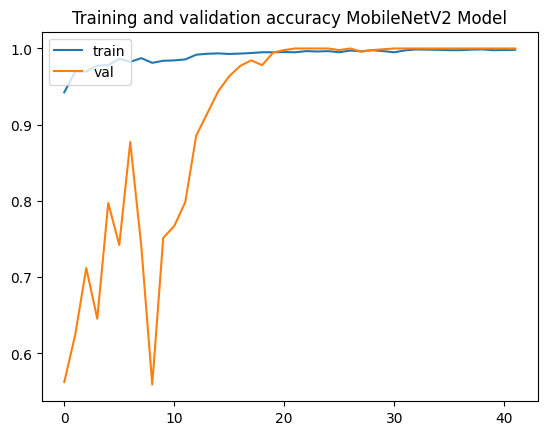

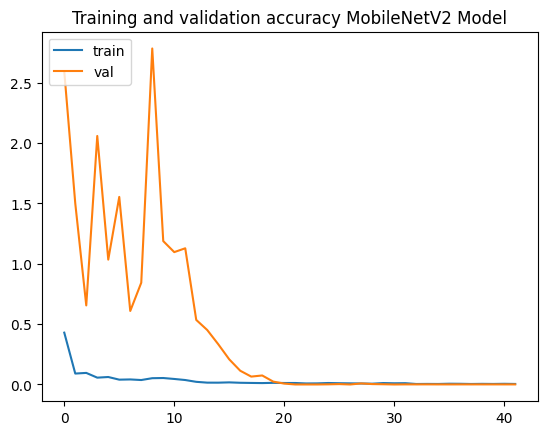

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation accuracy MobileNetV2 Model')

## MobileNetV2 Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9440
Epoch 1: val_accuracy improved from -inf to 0.49480, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 52s 240ms/step - loss: 0.1578 - accuracy: 0.9440 - val_loss: 2.1133 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9712
Epoch 2: val_accuracy improved from 0.49480 to 0.51871, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 48s 236ms/step - loss: 0.0788 - accuracy: 0.9712 - val_loss: 3.1555 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9707
Epoch 3: val_accuracy improved from 0.51871 to 0.73805, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 48s 236ms/step - loss: 0.0752 - accuracy: 0.9707 - val_loss: 1.2016 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9757
Epoch 4: val_accuracy did not improve from 0.73805
202/202 [==============================] - 33s 162ms/step - loss: 0.0626 - accuracy: 0.9757 - val_loss: 14.5972 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9817
Epoch 5: val_accuracy did not improve from 0.73805
202/202 [==============================] - 32s 159ms/step - loss: 0.0399 - accuracy: 0.9817 - val_loss: 29.7671 - val_accuracy: 0.5166 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9777
Epoch 6: val_accuracy did not improve from 0.73805
202/202 [==============================] - 34s 169ms/step - loss: 0.0646 - accuracy: 0.9777 - val_loss: 6.8240 - 

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 50s 247ms/step - loss: 0.0260 - accuracy: 0.9886 - val_loss: 2.0788 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 11/100
202/202 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9916
Epoch 11: val_accuracy improved from 0.79002 to 0.87006, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 49s 243ms/step - loss: 0.0202 - accuracy: 0.9916 - val_loss: 1.0684 - val_accuracy: 0.8701 - lr: 1.0000e-04
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9906
Epoch 12: val_accuracy improved from 0.87006 to 0.95114, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 49s 240ms/step - loss: 0.0196 - accuracy: 0.9906 - val_loss: 0.2806 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 13/100
202/202 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9928
Epoch 13: val_accuracy improved from 0.95114 to 0.96985, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 51s 249ms/step - loss: 0.0168 - accuracy: 0.9928 - val_loss: 0.1544 - val_accuracy: 0.9699 - lr: 1.0000e-04
Epoch 14/100
202/202 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9931
Epoch 14: val_accuracy improved from 0.96985 to 0.98649, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 51s 251ms/step - loss: 0.0149 - accuracy: 0.9931 - val_loss: 0.0614 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 15/100
202/202 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9928
Epoch 15: val_accuracy improved from 0.98649 to 0.99376, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 51s 252ms/step - loss: 0.0169 - accuracy: 0.9928 - val_loss: 0.0206 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 16/100
202/202 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9936
Epoch 16: val_accuracy improved from 0.99376 to 0.99896, saving model to BellPaper_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 51s 249ms/step - loss: 0.0145 - accuracy: 0.9936 - val_loss: 0.0083 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 17/100
202/202 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9943
Epoch 17: val_accuracy did not improve from 0.99896
202/202 [==============================] - 36s 177ms/step - loss: 0.0121 - accuracy: 0.9943 - val_loss: 0.0032 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 18/100
202/202 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9963
Epoch 18: val_accuracy did not improve from 0.99896
202/202 [==============================] - 36s 178ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0062 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 19/100
202/202 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9948
Epoch 19: val_accuracy did not improve from 0.99896
202/202 [==============================] - 36s 176ms/step - loss: 0.0117 - accuracy: 0.9948 - val

INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_MobileNetV2_model2_Based_Augmented\assets


202/202 [==============================] - 57s 284ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 7.0590e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 31/100
202/202 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960
Epoch 31: val_accuracy did not improve from 1.00000
202/202 [==============================] - 38s 188ms/step - loss: 0.0085 - accuracy: 0.9960 - val_loss: 5.1894e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 32/100
202/202 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9985
Epoch 32: val_accuracy did not improve from 1.00000
202/202 [==============================] - 37s 182ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 7.4217e-04 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 33/100
202/202 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9968
Epoch 33: val_accuracy did not improve from 1.00000
202/202 [==============================] - 36s 177ms/step - loss: 0.0088 - accuracy: 

Text(0.5, 1.0, 'Training and validation loss MobileNetV2 Model')

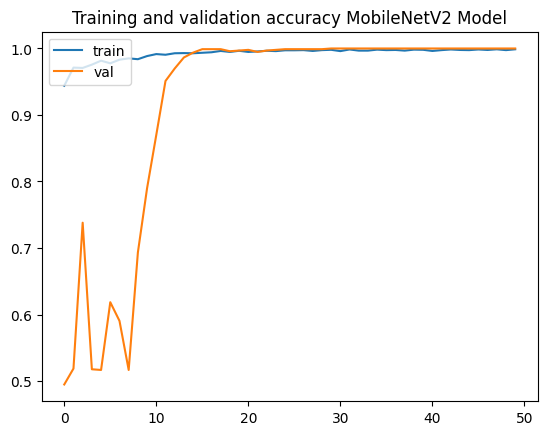

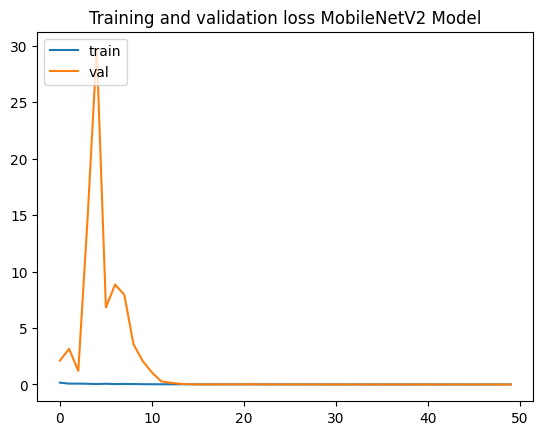

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.legend(['train', 'val'], loc='upper left')
plt.title ('Training and validation loss MobileNetV2 Model')